In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import TransferFunction, bode, lsim
from IPython.display import display, Image, Markdown
from scipy import interpolate
from scipy.optimize import least_squares
from scipy.integrate import solve_ivp
import pandas as pd

# Parameteridentifikation

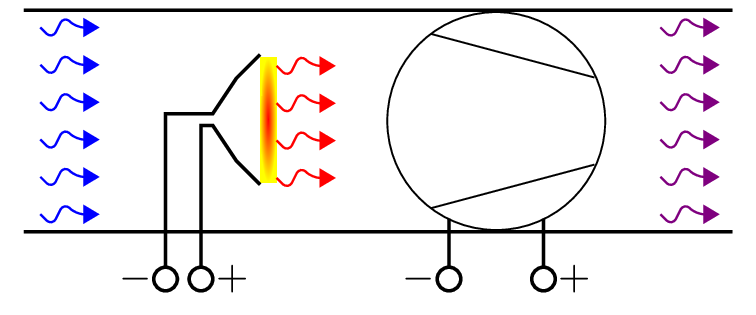

In [2]:
imag = Image("../../images/hvac.png", width=400)
display(imag)

**Nichtlineares Ausgangssystem**
\begin{align*}         
    \dot{x}(t) & = -\underbrace{\Big(\frac{v_{\mathrm{m}}}{l} + \frac{\alpha_{\mathrm{m}\infty} A_{\mathrm{M,m}}}{c_{\mathrm{p,m}} V_{\mathrm{m}}} \Big)}_{p_1} x(t) + \underbrace{\frac{\beta}{c_{\mathrm{p,m}} V_{\mathrm{m}}}}_{p_2} u(t) + \underbrace{\Big(\frac{v_{\mathrm{m}}}{l} + \frac{\alpha_{\mathrm{m}\infty} A_{\mathrm{M,m}}}{c_{\mathrm{p,m}} V_{\mathrm{m}}} \Big)}_{p_1} T_{\infty}\\
    y(t) & = x(t)
\end{align*}
mit den gesuchten unbekannten Parametern
\begin{align*}
    \mathbf{\hat{p}} & = \Big( p_1, p_2\Big)
\end{align*}

## Messung

In [3]:
dfData =  pd.read_csv('messungHVAC.csv')
dfData['DateTime'] = pd.to_timedelta(dfData['time'], unit='s')
dfData.set_index('DateTime', inplace=True)
dfData = dfData.resample('1S').ffill()

### Ruhelage

\begin{align*}         
    0 & = -\Big(\frac{v_{\mathrm{m}}}{l} + \frac{\alpha_{\mathrm{m}\infty} A_{\mathrm{M,m}}}{c_{\mathrm{p,m}} V_{\mathrm{m}}} \Big) \bar{x} + \frac{\beta}{c_{\mathrm{p,m}} V_{\mathrm{m}}} \bar{u} + \Big(\frac{v_{\mathrm{m}}}{l} + \frac{\alpha_{\mathrm{m}\infty} A_{\mathrm{M,m}}}{c_{\mathrm{p,m}} V_{\mathrm{m}}} \Big) T_{\infty}\\
    \bar{x} & = T_{\infty} \text{ für } \bar{u} = 0  
\end{align*}


In [4]:
bT = dfData['Pipe-T'][0:7].mean()
display(Markdown(rf"""
$\bar{{T}} = {bT}$
"""))
dfData['Pipe-T-Norm'] = dfData['Pipe-T'][:] - bT


$\bar{T} = 26.371981566820278$


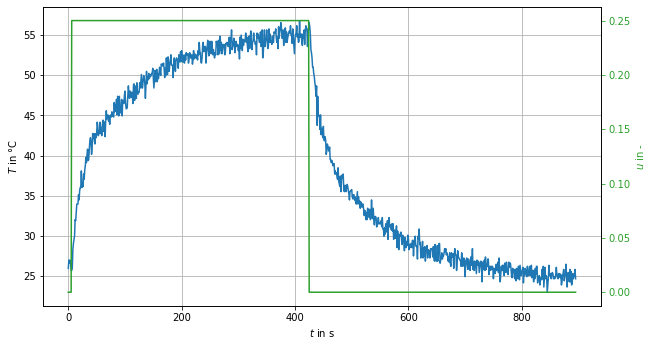

In [5]:
fig = plt.figure(figsize=(10, 5))
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.subplots_adjust(bottom=0.1, top=0.93, left=0.125, right=0.9)

ax1 = plt.subplot(111)
ax1.plot(dfData['time'], dfData['Pipe-T'])

ax1.grid()
ax1.set_xlabel(r'$t$ in s')
ax1.set_ylabel(r'$T$ in °C')

ax11 = ax1.twinx()
ax11.plot(dfData['time'], dfData['Traj y'], 'C2')
ax11.tick_params(axis='y', colors='C2')
ax11.set_ylabel('$u$ in -', color='C2');

## Identifikationsdaten

In [6]:
dfIdent = dfData.iloc[5:420].copy()
dfIdent.index = dfIdent.index - dfIdent.index[0]
dfIdent['time'] = dfIdent['time'] - dfIdent['time'][0]

## Systemdefinition

In [7]:
def nonlinSystem(t, y, a, b, Ta):
    dy = a * y + b * u(t) - a * Ta

    return [dy]

tSim = np.linspace(dfIdent['time'][0], dfIdent['time'][-1], len(dfIdent['time'].values))
u = interpolate.interp1d(dfIdent['time'], dfIdent['Traj y'], fill_value='extrapolate')

## 1. Variante - grafische Methode

**Linearisiertes System** um die Ruhelage $(\bar{x}, \bar{u})$ als lineares PT$_1$-Glied
\begin{align*}
    \dot{\tilde{y}}(t) & = a \tilde{y}(t) + b \tilde{u}(t) & \Leftrightarrow && T_1 \dot{\tilde{y}}(t) & = \tilde{y}(t) + K_{\mathrm{P}} \tilde{u}(t) 
\end{align*}

In [8]:
KpV1 = dfIdent['Pipe-T-Norm'][-1]
i = dfIdent['Pipe-T-Norm'][0:420].searchsorted(KpV1 * 0.63)
T1V1 = dfIdent['time'][i]
aV1 = - 1 / T1V1
bV1 = - KpV1 * aV1 * 1. / 0.25 # u = [0, 0.25] = [0, 1]

In [9]:
display(Markdown(rf"""
$K_{{\mathrm{{p}}}} = {KpV1}$, &nbsp; $T_1 = {T1V1}$, &nbsp; $a = {aV1}$, &nbsp; $b = {bV1}$
"""))


$K_{\mathrm{p}} = 29.78801843317972$, &nbsp; $T_1 = 76.0$, &nbsp; $a = -0.013157894736842105$, &nbsp; $b = 1.567790443851564$


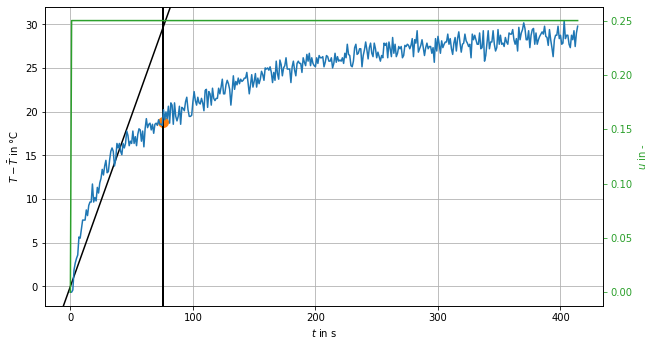

In [10]:
fig = plt.figure(figsize=(10, 5))
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.subplots_adjust(bottom=0.1, top=0.93, left=0.125, right=0.9)

ax1 = plt.subplot(111)
ax1.axvline(T1V1, linewidth=2, color='black')
ax1.scatter(T1V1, KpV1 * 0.63, marker='o', s=100, color='C1')
ax1.axline((T1V1, KpV1), slope=KpV1/T1V1, color='black')

ax1.plot(dfIdent['time'], dfIdent['Pipe-T-Norm'])

ax1.grid()
ax1.set_xlabel(r'$t$ in s')
ax1.set_ylabel(r'$T-\bar{T}$ in °C')

ax11 = ax1.twinx()
ax11.plot(dfIdent['time'], dfIdent['Traj y'], 'C2')
ax11.tick_params(axis='y', colors='C2')
ax11.set_ylabel('$u$ in -', color='C2');

## 2. Variante - lineares Least-Squares

**Linearisiertes System** um die Ruhelage $(\bar{x}, \bar{u})$ als lineares PT$_1$-Glied in Differenzenform
\begin{align*}
    \tilde{y}_{k+1} & = (1 + \check{a}) \tilde{y}_k + \check{b} \tilde{u}_k
\end{align*}
mit
\begin{align*}
    \check{a} & = \Delta t\, a, &
    \check{b} & = \Delta t\, b
\end{align*}

In [11]:
yk1 = dfIdent['Pipe-T-Norm'][1:]
yk = dfIdent['Pipe-T-Norm'][0:-1]
uk = dfIdent['Traj y'][0:-1]

In [12]:
Y = yk1.values
S = np.ones((len(Y), 2))
S[:, 0] = yk.values
S[:, 1] = uk.values

In [13]:
p = np.linalg.inv(S.T.dot(S)).dot(S.T).dot(Y)
aV2 = p[0] - 1
bV2 = p[1]

In [14]:
display(Markdown(rf"""
$a = {aV2}$, &nbsp; $b = {bV2}$
"""))


$a = -0.037594192616067224$, &nbsp; $b = 3.8459509308758775$


## 3. Variante - nichtlineares Least-Squares

**Nichtlineares System**
\begin{align*}         
    \dot{y}(t) & = -\Big(\frac{v_{\mathrm{m}}}{l} + \frac{\alpha_{\mathrm{m}\infty} A_{\mathrm{M,m}}}{c_{\mathrm{p,m}} V_{\mathrm{m}}} \Big) y(t) + \frac{\beta}{c_{\mathrm{p,m}} V_{\mathrm{m}}} u(t) + \Big(\frac{v_{\mathrm{m}}}{l} + \frac{\alpha_{\mathrm{m}\infty} A_{\mathrm{M,m}}}{c_{\mathrm{p,m}} V_{\mathrm{m}}} \Big) T_{\infty}\\
    & = - a y(t) + b u(t) + a T_{\infty}
\end{align*}

In [15]:
def optSys(p):
    y0 = [dfIdent['Pipe-T'][0]]
    res = solve_ivp(nonlinSystem,
                    [tSim[0], tSim[-1]],
                    y0,
                    t_eval=tSim, 
                    args=(p[0], p[1], dfIdent['Pipe-T'][0]))
    return dfIdent['Pipe-T'].values - res.y[0]

In [16]:
y0 = np.array([0.01, 0.01])
resLq = least_squares(optSys, y0)
aV3 = resLq.x[0]
bV3 = resLq.x[1]

## Validierung

In [18]:
display(Markdown(rf"""
|                     | Variante 1  | Variante 2  | Variante 3 |
| :---                | :----:      | :----:      | ---:       |
| $a$                 | {aV1}       | {aV2}       | {aV3}      |
| $b$                 | {bV1}       | {bV2}       | {bV3}      |
"""))


|                     | Variante 1  | Variante 2  | Variante 3 |
| :---                | :----:      | :----:      | ---:       |
| $a$                 | -0.013157894736842105       | -0.037594192616067224       | -0.017187663474073585      |
| $b$                 | 1.567790443851564       | 3.8459509308758775       | 1.928406236491234      |


In [19]:
y0 = [dfIdent['Pipe-T'][0]]
resV1 = solve_ivp(nonlinSystem,
                  [tSim[0], tSim[-1]],
                  y0,
                  t_eval=tSim, 
                  args=(aV1, bV1, dfIdent['Pipe-T'][0]))
resV2 = solve_ivp(nonlinSystem,
                  [tSim[0], tSim[-1]],
                  y0,
                  t_eval=tSim, 
                  args=(aV2, bV2, dfIdent['Pipe-T'][0]))
resV3 = solve_ivp(nonlinSystem,
                  [tSim[0], tSim[-1]],
                  y0,
                  t_eval=tSim, 
                  args=(aV3, bV3, dfIdent['Pipe-T'][0]))

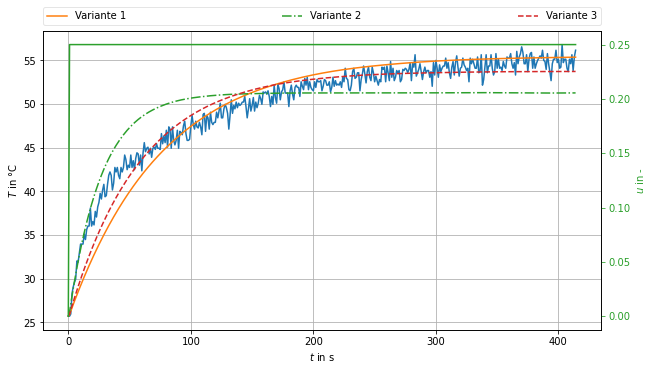

In [24]:
fig = plt.figure(figsize=(10, 5))
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.subplots_adjust(bottom=0.1, top=0.93, left=0.125, right=0.9)
ax1 = plt.subplot(111)
ax1.plot(dfIdent['time'], dfIdent['Pipe-T'])
ax1.plot(resV1.t, resV1.y.T, label='Variante 1')
ax1.plot(resV2.t, resV2.y.T, '-.', label='Variante 2')
ax1.plot(resV3.t, resV3.y.T, '--', label='Variante 3')

ax1.grid()
ax1.set_xlabel(r'$t$ in s')
ax1.set_ylabel(r'$T$ in °C')

handlesAx1, labelsAx1 = ax1.get_legend_handles_labels()
ax1.legend([handle for i, handle in enumerate(handlesAx1)],
           [label for i, label in enumerate(labelsAx1)],
           bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0., framealpha=0.5)

ax11 = ax1.twinx()
ax11.plot(dfIdent['time'], dfIdent['Traj y'], 'C2')
ax11.tick_params(axis='y', colors='C2')
ax11.set_ylabel(r'$u$ in -', color='C2')
plt.show()